<a href="https://colab.research.google.com/github/SkandarEverest/praktikum_ml/blob/main/23525040_23525046_IF5140_Praktikum_4_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset dan Libraries

In [ ]:
!pip install kmedoids

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kmedoids import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import warnings

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Overview Dataset

Dataset ini merupakan dataset yang bertujuan untuk pembelajaran mengenai *Penguins Species Dataset* dengan menggunakan unsupervised learning.

Link dataset: https://drive.google.com/file/d/1xfqZMn_bB434NsITBxjAWQOdGiIjlmuZ/view?usp=sharing

Informasi atribut dataset:

* ID: Unique ID dari Penguin
* culmen_length_mm: Panjang culmen (mm) dari penguin.
* culmen_depth_mm: Kedalaman culmen (mm) dari penguin.
* flipper_length_mm: Panjang sirip (mm) dari penguin.
* body_mass_g: Massa tubuh (g) dari penguin.
*   sex: Jenis kelamin dari penguin.






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/machine learning/dataset/Penguins_dataset.csv')
df.head()

,ID,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,1,39.1,18.7,181.0,3750.0,MALE
1,2,39.5,17.4,186.0,3800.0,FEMALE
2,3,40.3,18.0,195.0,3250.0,FEMALE
3,4,NaN,NaN,NaN,NaN,NaN
4,5,36.7,19.3,193.0,3450.0,FEMALE


<Axes: >

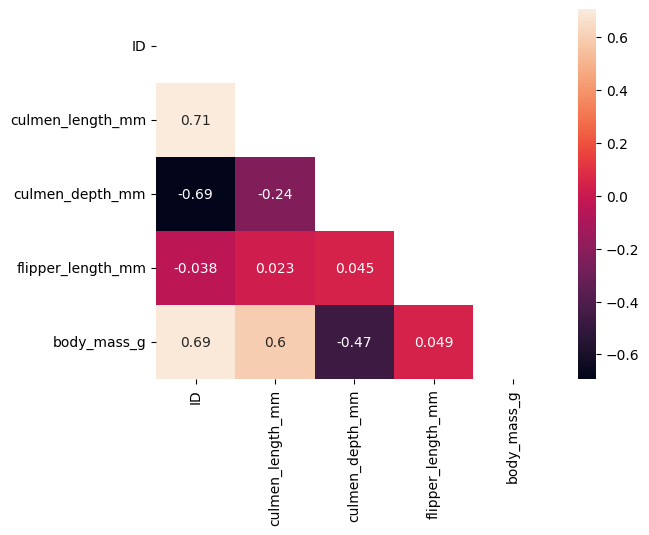

In [ ]:
num_df = df.select_dtypes(include=["float64", "int64"]).corr()
mask = np.triu(np.ones_like(num_df, dtype=bool))

sns.heatmap(num_df, annot=True, mask=mask)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 344 non-null    int64  
 1   culmen_length_mm   342 non-null    float64
 2   culmen_depth_mm    342 non-null    float64
 3   flipper_length_mm  342 non-null    float64
 4   body_mass_g        342 non-null    float64
 5   sex                335 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 16.3+ KB


In [ ]:
df.isnull().sum()

,0
ID,0
culmen_length_mm,2
culmen_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,9


# EDA & Data Preprocessing


## EDA
Lakukan eksplorasi sederhana secara statistik pada dataset, beberapa fungsi hal yang krusial untuk diexplorasi:
* Statistik deskriptif dari dataset
* Informasi mengenai  dataset
* Hubungan antar variable

Jelaskan hasil eksplorasi pada notebook!

Weve got some null values. As they are so small as a proportion of our total dataset, we're going to simply drop them prior to the EDA and forgoe any imputation.

In [ ]:
df.dropna(subset=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 335 non-null    int64  
 1   culmen_length_mm   335 non-null    float64
 2   culmen_depth_mm    335 non-null    float64
 3   flipper_length_mm  335 non-null    float64
 4   body_mass_g        335 non-null    float64
 5   sex                335 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,335.0,173.304478,97.875837,1.0,89.5,173.0,257.50,344.0
culmen_length_mm,335.0,43.988358,5.453430,32.1,39.5,44.5,48.55,59.6
culmen_depth_mm,335.0,17.169552,1.971966,13.1,15.6,17.3,18.70,21.5
flipper_length_mm,335.0,214.355224,263.253508,-132.0,190.0,197.0,213.00,5000.0
body_mass_g,335.0,4209.179104,803.633495,2700.0,3550.0,4050.0,4787.50,6300.0


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
sex,335,3,MALE,169


In [ ]:
df['sex']

,sex
0,MALE
1,FEMALE
2,FEMALE
3,FEMALE
4,MALE
...,...
330,FEMALE
331,FEMALE
332,MALE
333,FEMALE


In [ ]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

In [ ]:
df = df[df['sex'] != '.']

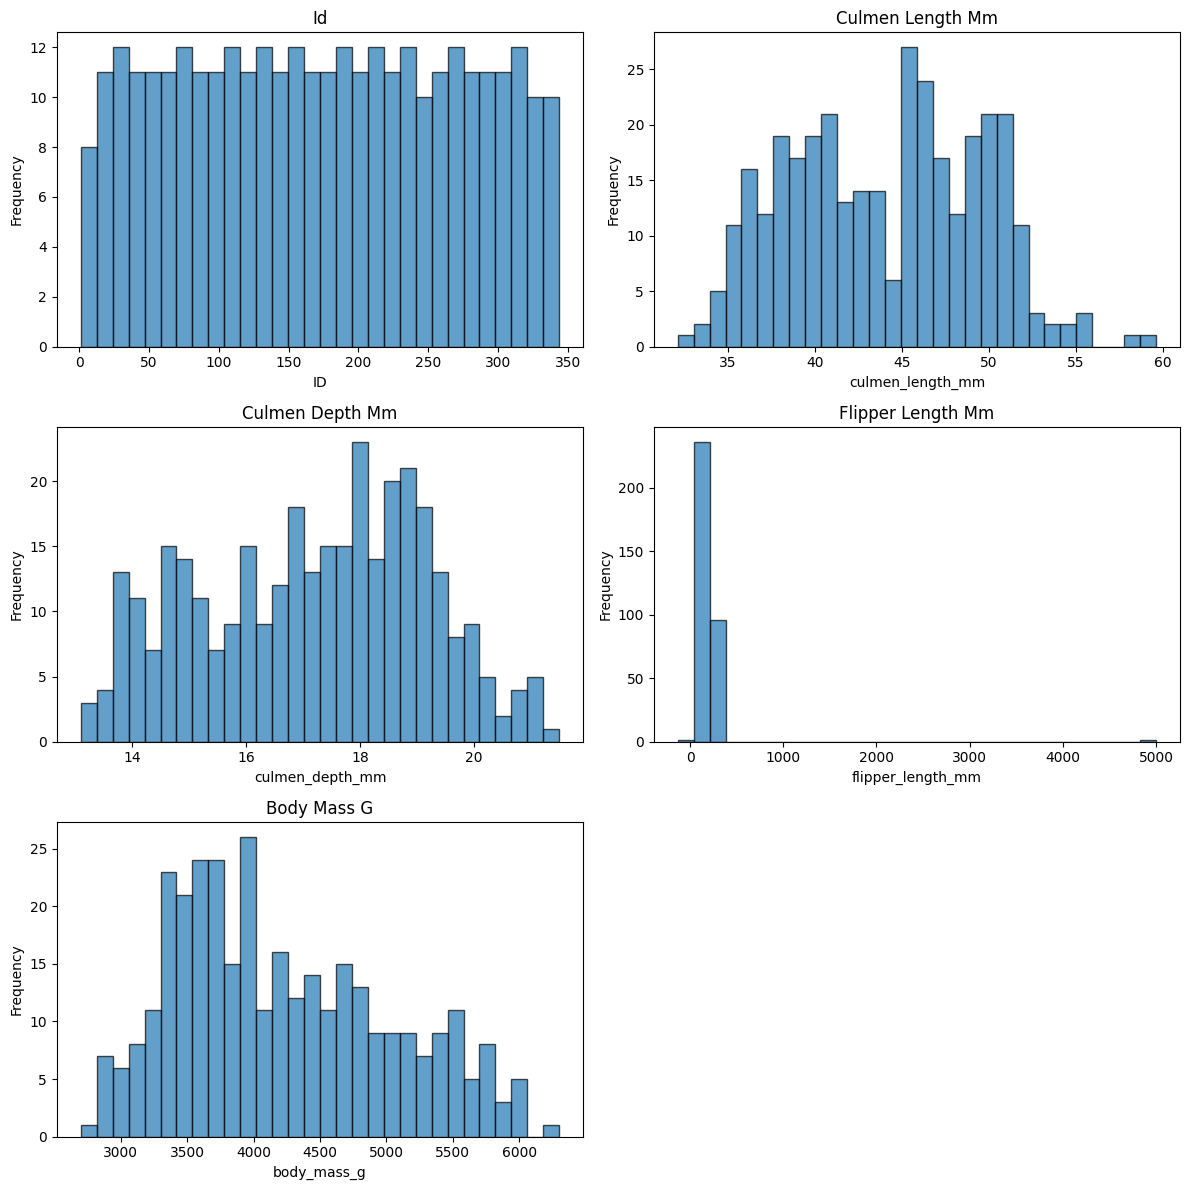

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

n_cols = 2
n_rows = int(np.ceil(len(numeric_df.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

axes = axes.ravel()

for ax, col in zip(axes, numeric_df.columns):
    ax.hist(numeric_df[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col.replace("_", " ").title())
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

for i in range(len(numeric_df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
df.sort_values(by='flipper_length_mm', ascending=True).head(3)

,ID,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
10,15,34.6,21.1,-132.0,4400.0,MALE
24,29,37.9,18.6,172.0,3150.0,FEMALE
16,21,37.8,18.3,174.0,3400.0,FEMALE


In [ ]:
df = df[df['flipper_length_mm'] != 5000.0]
df = df[df['flipper_length_mm'] != -132.0]

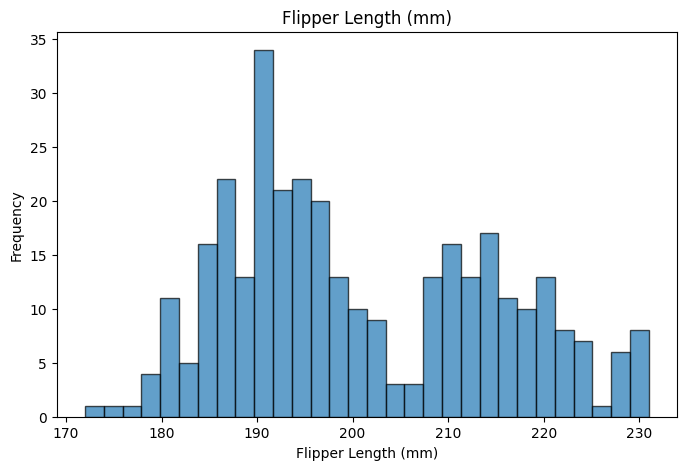

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df['flipper_length_mm'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Flipper Length (mm)')
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Frequency')
plt.show()

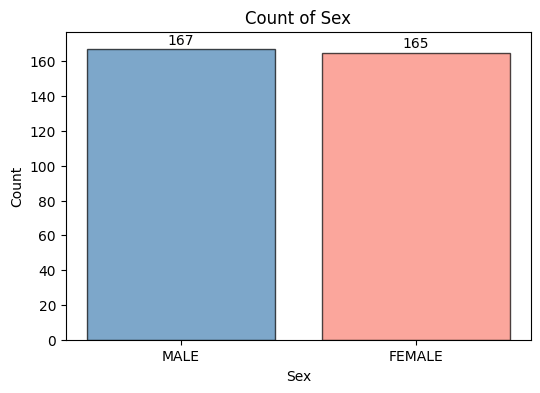

In [ ]:
counts = df['sex'].value_counts()
colors = ['steelblue' if sex != 'FEMALE' else 'salmon' for sex in counts.index]  # set Female to salmon

plt.figure(figsize=(6,4))
bars = plt.bar(counts.index, counts.values, color=colors, edgecolor='black', alpha=0.7)

# Add counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.title('Count of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.ylim(0, counts.values.max() + 10)  # add some space above the tallest bar
numeric_df = df.select_dtypes(include=[np.number])
plt.show()

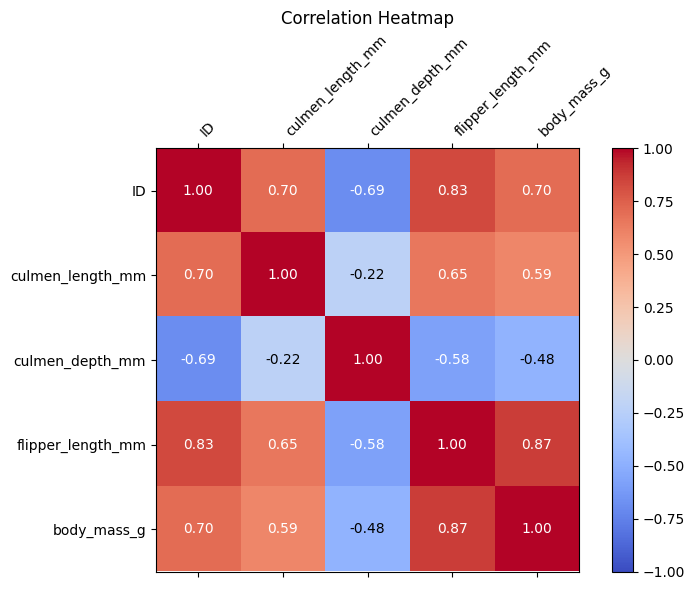

In [ ]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()

corr_matrix = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the correlation matrix as a heatmap
cax = ax.matshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)

# Add colorbar
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha="left")
ax.set_yticklabels(num_cols)

# Annotate each cell with correlation value
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        c = corr_matrix.iloc[i, j]
        ax.text(j, i, f"{c:.2f}", va="center", ha="center", color="black" if abs(c)<0.5 else "white")

ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()

## Lakukan Data Preprocessing
Data preprocessing dilakukan untuk menghasilkan dataset yang lebih bersih, lebih akurat, dan lebih konsisten. Lakukan data preprocessing dengan bantuan beberapa fungsi yang krusial berikut:
* isnull
* duplicated

Anda diperbolehkan untuk melakukan preprocessing dengan fungsi lainnya.

In [ ]:
df = df.drop_duplicates()
df = df.dropna()
df = df.drop(columns=["ID"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332 entries, 0 to 334
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 15.6+ KB


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"])
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,36.7,19.3,193.0,3450.0,0
4,39.3,20.6,190.0,3650.0,1


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df)
penguins_preprocessed = pd.DataFrame(data=X, columns=df.columns)
penguins_preprocessed.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.903906,0.790360,-1.425342,-0.566948,0.993994
1,-0.830434,0.126187,-1.068577,-0.504847,-1.006042
2,-0.683490,0.432728,-0.426399,-1.187953,-1.006042
3,-1.344738,1.096901,-0.569105,-0.939551,-1.006042
4,-0.867170,1.761074,-0.783164,-0.691149,0.993994
5,-0.940642,0.330548,-1.425342,-0.722199,-1.006042
6,-0.885538,1.250172,-0.426399,0.581912,0.993994
7,-0.536545,0.228367,-1.353989,-1.250054,-1.006042
8,-0.995746,2.067616,-0.711811,-0.504847,0.993994
9,-1.363106,0.330548,-1.139930,-0.629049,-1.006042


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]])
df_scaled = np.concatenate((df_scaled, df[["sex"]]), axis=1)
df_scaled

array([[0.25454545, 0.66666667, 0.15254237, 0.29166667, 1.        ],
       [0.26909091, 0.51190476, 0.23728814, 0.30555556, 0.        ],
       [0.29818182, 0.58333333, 0.38983051, 0.15277778, 0.        ],
       ...,
       [0.66545455, 0.30952381, 0.84745763, 0.84722222, 1.        ],
       [0.47636364, 0.20238095, 0.6779661 , 0.69444444, 0.        ],
       [0.64727273, 0.35714286, 0.69491525, 0.75      , 1.        ]])

# PCA (BONUS)
PCA merupakan salah satu cara untuk melakukan transformasi pada sebuah fitur dengan melakukan pengurangan jumlah fitur dalam dataset sambil mempertahankan sebanyak mungkin informasi (variansi) dari data asli. Untuk mengetahui dampak PCA terhadap fitur pada data, lakukan beberapa hal ini:
* Lakukan Principal Component Analysis (PCA) pada data.
* Tentukan rasio variansi yang dijelaskan oleh beberapa komponen utama pertama.
* Hitung jumlah kumulatif dari rasio variansi yang dijelaskan oleh komponen-komponen utama tersebut.
* Buatlah visualisasi berikut:
  * Gunakan bar plot untuk menampilkan rasio variansi yang dijelaskan oleh masing-masing komponen utama.
  * Gunakan step plot untuk menampilkan jumlah kumulatif variansi yang dijelaskan oleh komponen-komponen utama.
* Tentukan apakah PCA perlu dilakukan sebagai tahapan dalam proses clustering ini? Berikan alasannya!

In [ ]:
pca = PCA(n_components=None)
dfx_pca = pca.fit(penguins_preprocessed)
dfx_pca.explained_variance_ratio_
n_components = sum(dfx_pca.explained_variance_ratio_ > 0.1)
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)
print(n_components)

2


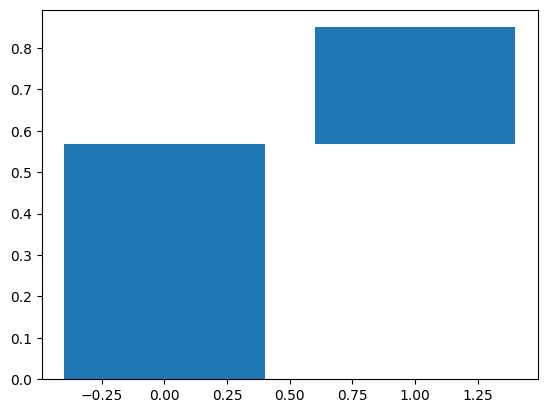

In [ ]:
def waterfall(data):
  bottom_pos = []
  for i,j in enumerate(data):
    if i == 0:
      bottom_pos.append(0)
    else:
      bottom_pos.append(data[i-1] + bottom_pos[i-1])
  plt.bar(range(len(data)), data, bottom=np.array(bottom_pos))
  plt.show()
waterfall(pca.explained_variance_ratio_)

# Modeling
Dalam rangka segmentasi pelanggan menggunakan clustering, pilihlah katergori yang anda pertimbangkan mampu merepresentasikan cluster dari pelanggan dengan baik. Harapannya ada beberapa algoritma yang untuk digunakan, yaitu:


## Algoritma K-Means
Tahapan:
* Dikarenakan K-Means sensitif terhadap jarak antara titik-titik data maka lakukan penskalaan data menggunakan StandardScaler sehingga hasil clustering menjadi lebih optimal.
* Gunakan metode "elbow" untuk memutuskan jumlah cluster yang optimal.
* Lakukan clustering dengan K-Means dengan tiga variasi jumlah cluster berbeda, saran variasi: k-1 optimal, k optimal, dan k+1 optimal
* Visualisasikan hasil clustering berdasarkan fitur yang digunakan (gunakan 2 fitur terbaik yang dapat merepresentasikan clustering jika clustering dilakukan > 2 fitur). Pastikan setiap cluster ditampilkan dengan warna berbeda, dengan legend yang jelas.
* Lakukan analisis mengenai variasi mana yang paling menggambarkan karakteristik data, dan jelaskan mengapa.

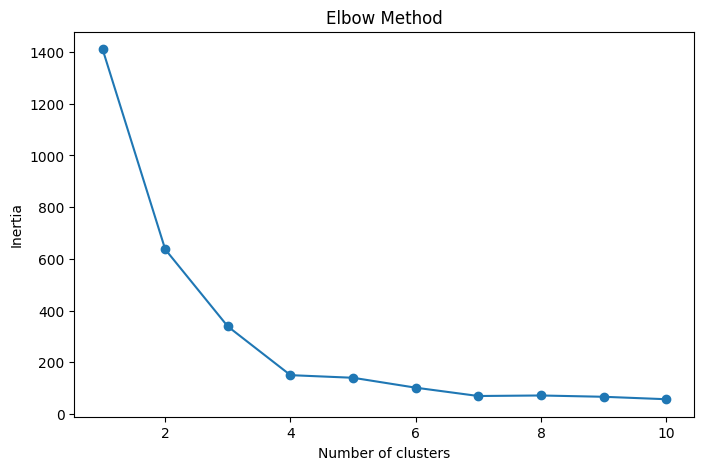

k* = 4  -> k_choices: [3, 4, 5]


In [ ]:
def elbow_method(data, max_clusters):
    inertia = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

    ks = np.arange(1, max_clusters + 1, dtype=int)
    y  = np.array(inertia, dtype=float)

    x1, y1 = ks[0], y[0]
    x2, y2 = ks[-1], y[-1]

    num  = np.abs((y2 - y1)*ks - (x2 - x1)*y + x2*y1 - y2*x1)
    den  = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    dist = num / den

    k_star = int(ks[np.argmax(dist)])
    k_choices = sorted(set([max(2, k_star - 1), max(2, k_star), min(k_star + 1, ks[-1])]))
    print("k* =", k_star, " -> k_choices:", k_choices)

    return (k_star, k_choices)

k_star, k_choices = elbow_method(penguins_PCA, 10)

In [ ]:
kmeans = KMeans(n_clusters=k_star, random_state=42)
kmeans.fit(penguins_PCA)

KMeans(n_clusters=4, random_state=42)

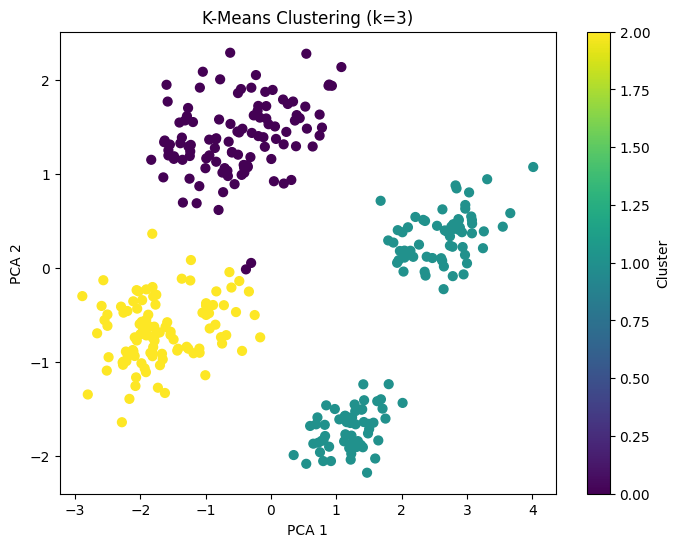

Silhouette score (k=3): 0.5701


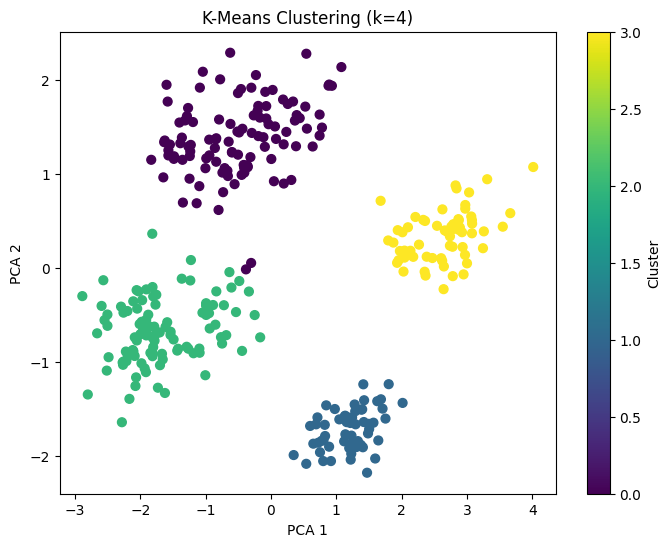

Silhouette score (k=4): 0.6552


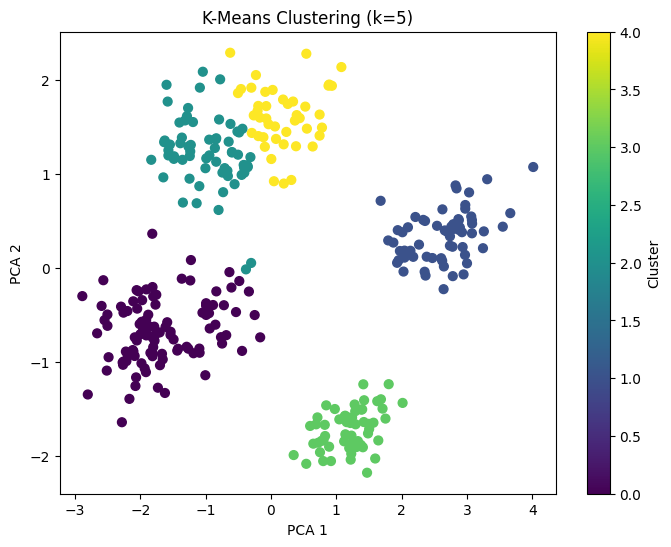

Silhouette score (k=5): 0.6012
Dari hasil elbow, k optimal adalah 4
Variasi k untuk eksperimen: [3, 4, 5]


In [ ]:
for k in k_choices:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(penguins_PCA)

    plt.figure(figsize=(8, 6))
    plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=labels, cmap='viridis', s=40)
    plt.title(f'K-Means Clustering (k={k})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(label='Cluster')
    plt.show()

    if k > 1:
        score = silhouette_score(penguins_PCA, labels)
        print(f"Silhouette score (k={k}): {score:.4f}")

print(f"Dari hasil elbow, k optimal adalah {k_star}")
print("Variasi k untuk eksperimen:", k_choices)


## Algoritma K-Medoid
Tahapan:
* Algoritma K-Medoid sensitif terhadap jarak antar titik data, namun karena ia lebih robust terhadap outliers dibanding K-Means, lakukan penskalaan data menggunakan StandardScaler hanya jika diperlukan untuk memastikan bahwa fitur memiliki skala yang sama.
* Gunakan metode silhouette score untuk mengevaluasi jumlah cluster yang optimal.
* Lakukan clustering dengan K-Medoid dengan tiga variasi jumlah cluster
berbeda, saran variasi: k-1 optimal, k optimal, dan k+1 optimal
* Visualisasikan hasil clustering berdasarkan fitur yang digunakan (gunakan 2 fitur terbaik yang dapat merepresentasikan clustering jika clustering dilakukan > 2 fitur). Pastikan setiap cluster ditampilkan dengan warna berbeda, dengan legend yang jelas.
* Lakukan analisis mengenai variasi mana yang paling menggambarkan karakteristik data, dan jelaskan mengapa.

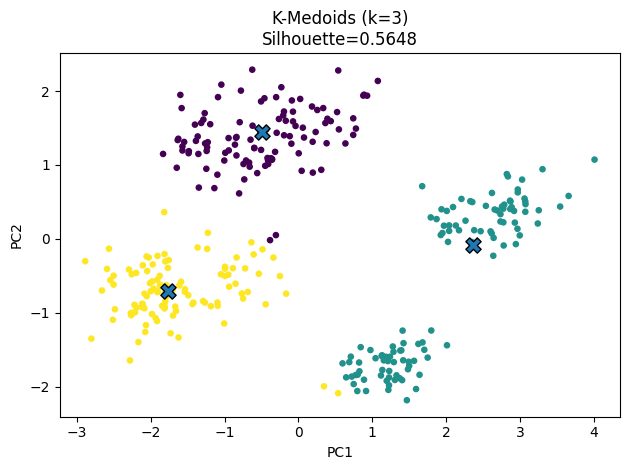

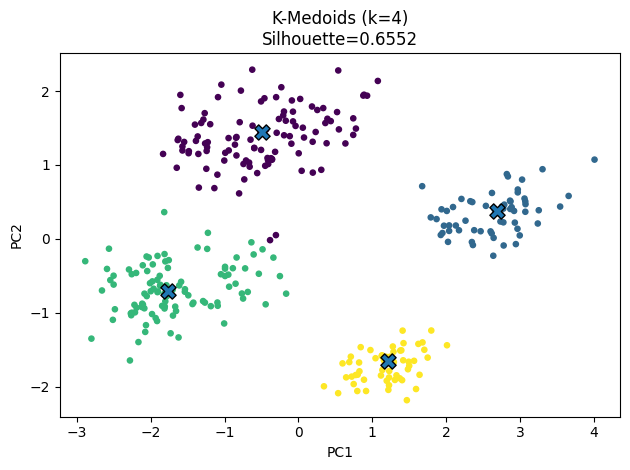

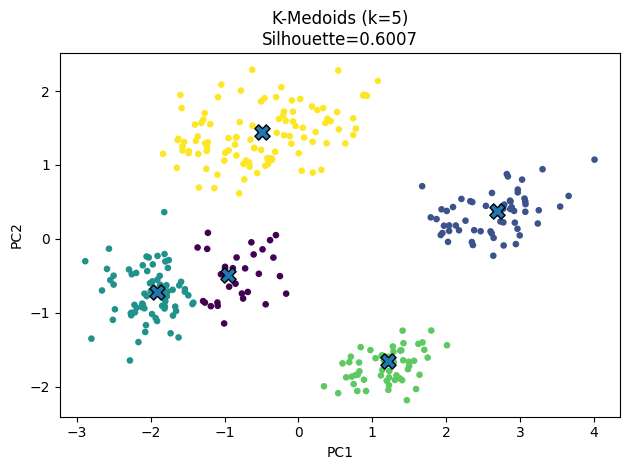

K-Medoids results (k, silhouette): [(3, np.float64(0.5648)), (4, np.float64(0.6552)), (5, np.float64(0.6007))]
Best K-Medoids: 4 Silhouette: 0.6552
Medoid indices: [ 46 228  49 215]


In [ ]:
X_kmed = penguins_PCA
X2 = X_kmed[:, :2] if X_kmed.shape[1] >= 2 else X_kmed  # for scatter

kmed_results = []
best_kmed = None
RANDOM_STATE = 42

for k in k_choices:
    km = KMedoids(
        n_clusters=k,
        method="fasterpam",
        metric="euclidean",
        init="build",
        random_state=RANDOM_STATE,
    ).fit(X_kmed)

    labels = km.labels_
    s = silhouette_score(X_kmed, labels) if k > 1 else np.nan
    kmed_results.append((k, s, labels, km.medoid_indices_))

    plt.figure()
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=14)
    meds2 = X2[km.medoid_indices_]
    plt.scatter(meds2[:, 0], meds2[:, 1], marker='X', s=120, edgecolor='k')
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"K-Medoids (k={k})\nSilhouette={s:.4f}")
    plt.tight_layout(); plt.show()

    if (best_kmed is None) or (s > best_kmed["silhouette"]):
        best_kmed = {
            "k": k,
            "labels": labels,
            "silhouette": s,
            "medoid_indices": km.medoid_indices_
        }

print("K-Medoids results (k, silhouette):", [(k, round(s, 4)) for k, s, *_ in kmed_results])
print("Best K-Medoids:", best_kmed["k"], "Silhouette:", round(best_kmed["silhouette"], 4))
print("Medoid indices:", best_kmed["medoid_indices"])


## Algoritma Agglomerative Hierarchical Clustering
Tahapan:
* Lakukan data preprocessing sehingga bisa dilakukan clustering dengan algortima hierarchical.
* Buat dendogram dari dataset untuk menentukan jumlah klaster yang optimal dan buat tiga variasi nilai k, saran variasi: klaster-1 optimal, klaster optimal, dan klaster+1 optimal
* Visualisasikan hasil clustering berdasarkan fitur yang digunakan (gunakan 2 fitur terbaik yang dapat merepresentasikan clustering jika clustering dilakukan > 2 fitur). Pastikan setiap cluster ditampilkan dengan warna berbeda, dengan legend yang jelas.
* Lakukan analisis mengenai variasi mana yang paling menggambarkan karakteristik data, dan jelaskan mengapa.

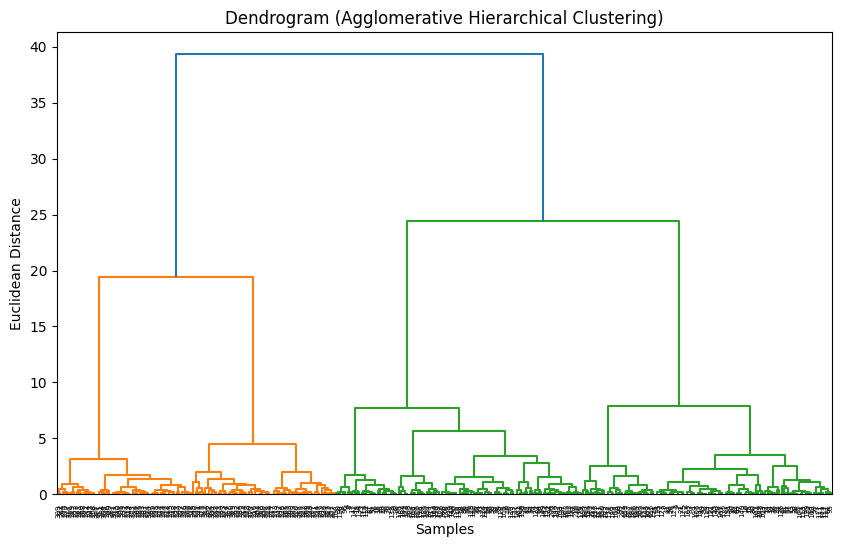

Variasi jumlah klaster: [3, 4, 5]


In [ ]:
plt.figure(figsize=(10, 6))
Z = linkage(penguins_PCA, method='ward')
dendrogram(Z)
plt.title('Dendrogram (Agglomerative Hierarchical Clustering)')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

k_optimal = 4
k_choices = [max(2, k_optimal - 1), k_optimal, k_optimal + 1]
print("Variasi jumlah klaster:", k_choices)

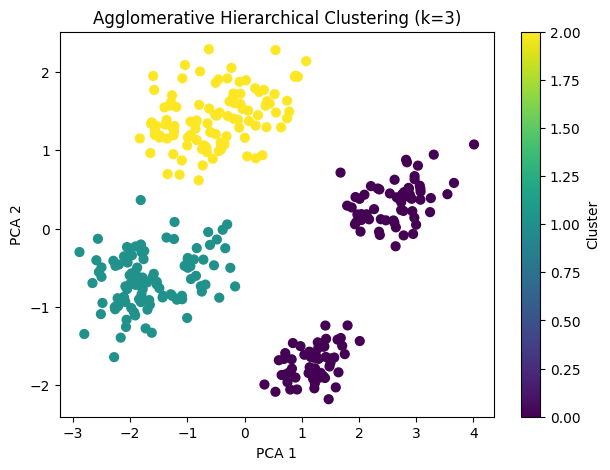

Silhouette score (k=3): 0.5700


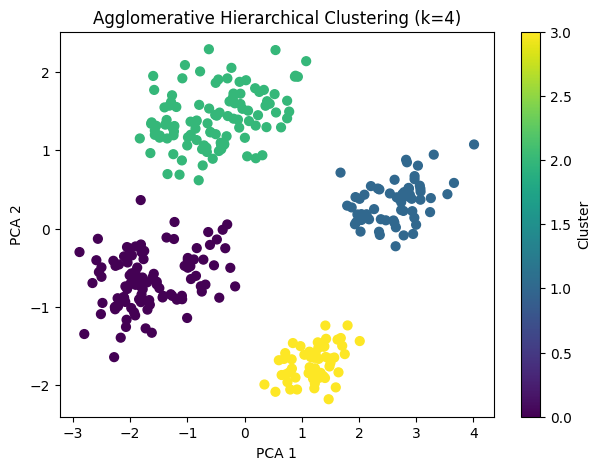

Silhouette score (k=4): 0.6552


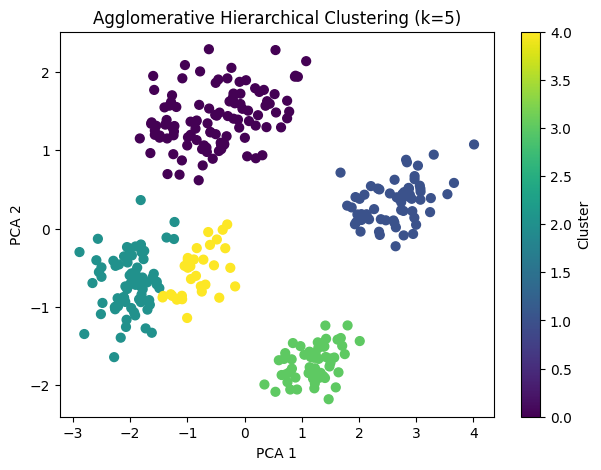

Silhouette score (k=5): 0.5956
Dari hasil elbow, k optimal adalah 4
Variasi k untuk eksperimen: [3, 4, 5]


In [ ]:
for k in k_choices:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(penguins_PCA)

    plt.figure(figsize=(7, 5))
    plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=labels, cmap='viridis', s=40)
    plt.title(f'Agglomerative Hierarchical Clustering (k={k})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(label='Cluster')
    plt.show()

    if k > 1:
        score = silhouette_score(penguins_PCA, labels)
        print(f"Silhouette score (k={k}): {score:.4f}")

print(f"Dari hasil elbow, k optimal adalah {k_star}")
print("Variasi k untuk eksperimen:", k_choices)


## Algoritma DBSCAN
Tahapan:
* Lakukan data preprocessing sehingga bisa dilakukan clustering dengan algortima DBSCAN.
* Lakukan clustering dengan nilai eps dengan tiga variasi jumlah cluster berbeda
* Visualisasikan hasil clustering berdasarkan fitur yang digunakan (gunakan 2 fitur terbaik yang dapat merepresentasikan clustering jika clustering dilakukan > 2 fitur). Pastikan setiap cluster ditampilkan dengan warna berbeda, dengan legend yang jelas.
* Lakukan analisis mengenai variasi mana yang paling menggambarkan karakteristik data, dan jelaskan mengapa.

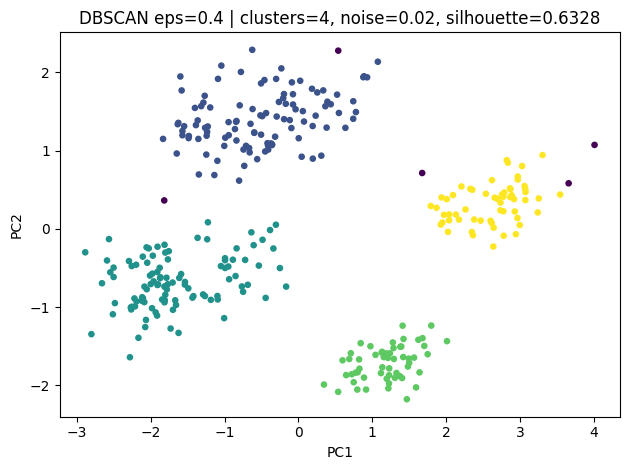

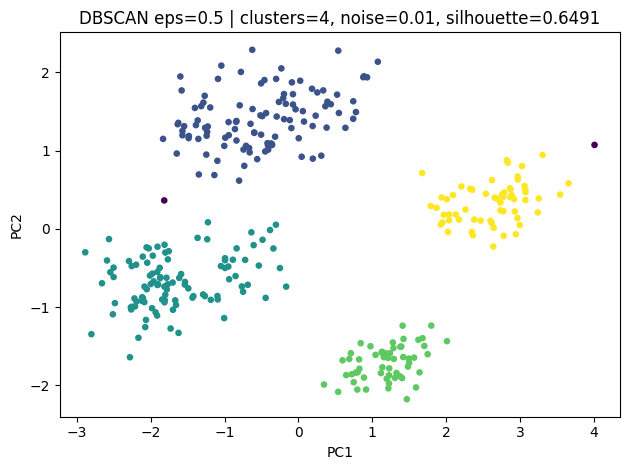

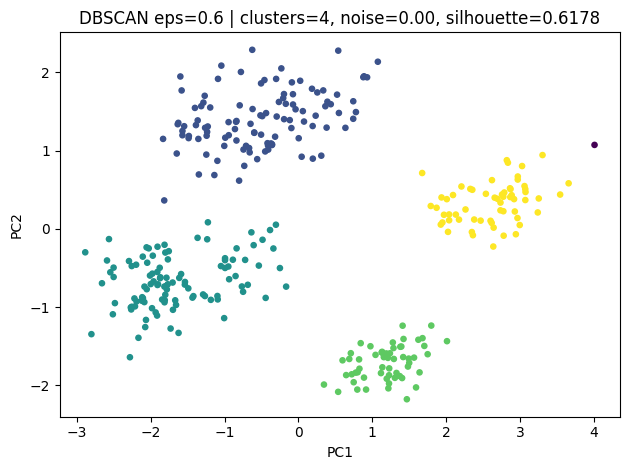

DBSCAN summary (eps, silhouette, clusters, noise_ratio, counts):
  eps=0.4: silhouette=0.6328, clusters=4, noise=0.02, counts={np.int64(-1): np.int64(5), np.int64(0): np.int64(105), np.int64(1): np.int64(106), np.int64(2): np.int64(58), np.int64(3): np.int64(58)}
  eps=0.5: silhouette=0.6491, clusters=4, noise=0.01, counts={np.int64(-1): np.int64(2), np.int64(0): np.int64(106), np.int64(1): np.int64(106), np.int64(2): np.int64(58), np.int64(3): np.int64(60)}
  eps=0.6: silhouette=0.6178, clusters=4, noise=0.00, counts={np.int64(-1): np.int64(1), np.int64(0): np.int64(107), np.int64(1): np.int64(106), np.int64(2): np.int64(58), np.int64(3): np.int64(60)}

Best (by silhouette): eps=0.5, silhouette=0.6491, clusters=4, noise=0.01


In [ ]:
X_db = penguins_PCA
X2   = X_db[:, :2] if X_db.shape[1] >= 2 else X_db

eps_list = [0.4, 0.5, 0.6]
min_samples = 5

summary = []
best = None

for eps in eps_list:
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_db)

    # metrics
    uniq, cnt = np.unique(labels, return_counts=True)
    counts = dict(zip(uniq, cnt))
    n_clusters = len([u for u in uniq if u != -1])
    noise_ratio = float(np.mean(labels == -1))
    sil = np.nan
    if n_clusters >= 2 and (labels != -1).any():
        try:
            sil = silhouette_score(X_db, labels)
        except Exception:
            sil = np.nan

    summary.append((eps, sil, n_clusters, noise_ratio, counts))

    # plot (simple)
    plt.figure()
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=14)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title(f"DBSCAN eps={eps} | clusters={n_clusters}, noise={noise_ratio:.2f}, "
              f"silhouette={None if np.isnan(sil) else round(sil,4)}")
    plt.tight_layout(); plt.show()

    # track best
    if best is None or (not np.isnan(sil) and sil > best["sil"]):
        best = {"eps": eps, "sil": sil, "k": n_clusters, "noise": noise_ratio, "counts": counts}

print("DBSCAN summary (eps, silhouette, clusters, noise_ratio, counts):")
for eps, sil, k, nz, c in summary:
    print(f"  eps={eps}: silhouette={None if np.isnan(sil) else round(sil,4)}, "
          f"clusters={k}, noise={nz:.2f}, counts={c}")

print("\nBest (by silhouette):",
      f"eps={best['eps']}, silhouette={None if np.isnan(best['sil']) else round(best['sil'],4)}, "
      f"clusters={best['k']}, noise={best['noise']:.2f}")

# Evaluation

## Penjelasan Metrik  

Dalam praktikum ini, kita akan menggunakan Silhouette Coefficient atau Silhouette Score untuk menghitung performa dari clustering. Silhouette Coefficient merupakan salah satu metrik yang digunakan untuk menghitung performa cluster pada dataset yang tidak memiliki ground truth label. Metrik ini menghitung score relatif setiap cluster dengan cluster lainnya dengan rentang nilai -1 - 1, dimana:

* 1: Berarti cluster jelas terpisah satu sama lain dan dapat dibedakan dengan jelas.
* 0: Berarti cluster tidak menunjukkan perbedaan, atau bisa dikatakan bahwa jarak antar cluster tidak signifikan.
* -1: Berarti cluster ditempatkan dengan cara yang salah.


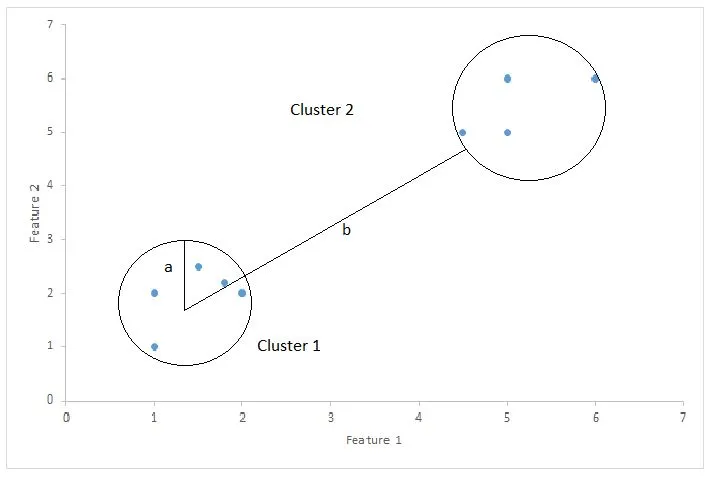

Untuk menghitung score satu cluster ke cluster lainnya adalah sebagai berikut:

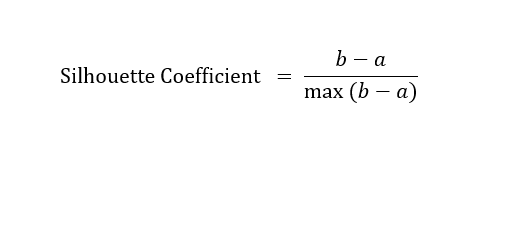

di mana

a = jarak rata-rata intra-cluster yaitu jarak rata-rata antara setiap titik dalam sebuah cluster.

b = jarak rata-rata antar-cluster yaitu jarak rata-rata antara semua cluster.

### KMEANS
Beberapa nilai *k* diuji (`k = 3, 4, 5`).  
Hasil menunjukkan bahwa **k = 4** memberikan nilai **silhouette tertinggi (0.655)** dibandingkan variasi lain.

**Alasan variasi terbaik:**
- Nilai silhouette meningkat dari `k=3` ke `k=4`, lalu menurun kembali di `k=5`.
- Artinya, pemisahan antar-cluster paling optimal terjadi pada `k=4`, karena nilai `0.655` menunjukkan cluster yang paling kompak dan terpisah dengan jelas.
- Pada `k=3`, cluster masih sedikit tumpang-tindih (indikasi masih ada data di batas antar-cluster).
- Pada `k=5`, penambahan cluster justru menurunkan nilai silhouette — tanda terjadinya over-segmentation, di mana cluster alami dipecah terlalu kecil.

### KMEDOIDS
Beberapa nilai *k* diuji (`k = 3, 4, 5`).  
Hasil menunjukkan bahwa **k = 4** memberikan nilai **silhouette tertinggi (0.6552)** dibandingkan variasi lain.

**Alasan variasi terbaik:**
- Nilai *silhouette* tertinggi menunjukkan pemisahan antar-cluster yang paling jelas serta kekompakan intrakluster yang baik.  
- Pada `k = 3`, cluster terlalu besar dan heterogen; pada `k = 5`, data mulai terfragmentasi.  
- `k = 4` menghasilkan pembagian yang seimbang dan mudah diinterpretasikan.  
- Medoid yang terpilih (`[46, 228, 49, 215]`) merepresentasikan pusat cluster yang stabil dan tahan terhadap *outlier*.

### Agglomerative Hierarchical
Beberapa nilai *k* diuji (`k = 3, 4, 5`).  
Hasil menunjukkan bahwa **k = 4** memberikan nilai **silhouette tertinggi (0.655)** dibandingkan variasi lain.

**Alasan variasi terbaik:**
- Nilai silhouette meningkat dari `k=3` ke `k=4`, lalu menurun pada `k=5`.
- Hal ini menunjukkan bahwa pemisahan antar cluster paling optimal terjadi pada `k=4`, karena nilai `0.655` adalah yang tertinggi.
- Pada `k=5`, nilai silhouette menurun yang menandakan cluster menjadi terlalu kecil dan mulai kehilangan struktur alami data.
- Hasil ini konsisten dengan hasil dendrogram yang menunjukkan beberapa cabang besar namun masih memungkinkan adanya satu subcluster tambahan.

### DBSCAN
Beberapa nilai `eps` diuji (`eps = 0.4, 0.5, 0.6`) dengan `min_samples = 5`.  
Variasi terbaik diperoleh pada **`eps = 0.5`** dengan **silhouette = 0.6491**, **4 cluster**, dan **proporsi noise sekitar 1%**.

**Alasan variasi terbaik:**
- `eps = 0.4` terlalu kecil → banyak titik dianggap *noise* (terlalu ketat).  
- `eps = 0.6` terlalu besar → beberapa cluster bergabung sehingga silhouette menurun.  
- `eps = 0.5` memberikan keseimbangan terbaik antara jumlah cluster, pemisahan yang jelas, dan noise minimal.  
- Jumlah cluster konsisten (4), sejalan dengan hasil K-Medoids, sehingga menunjukkan struktur alami data.

## Clustering Evaluation

Lakukan beberapa evaluasi terhadap hasil clustering menggunakan Silhoutte Coefficient, adapun evaluasi yang harus dijelaskan pada praktikum ini:
1. Penjelasan mengenai variasi terbaik dari clustering menggunakan K-means dan alasan variasi ini lebih baik daripada variasi lainnya.
2. Penjelasan variasi terbaik dari clustering menggunakan Hierarchical Clustering dan alasan variasi ini lebih baik daripada variasi lainnya.
3. Penjelasan variasi terbaik dari clustering menggunakan DBSCAN dan alasan variasi ini lebih baik daripada variasi lainnya.
4. Penjelasan algortima terbaik dari untuk melakukan clustering dan dan alasan algoritma ini lebih baik daripada algoritma lainnya.

### Perbandingan Antar Algoritma

| **Algoritma** | **Variasi Terbaik** | **Silhouette Score** | **Jumlah Cluster** | **Karakteristik Hasil** |
|---------------|----------------------|----------------------:|--------------------:|--------------------------|
| **K-Means** | k = 4 | **0.6552** | 4 | Pemisahan cluster kuat, kompak, dan stabil. Sensitif terhadap outlier namun sangat efektif pada data berdistribusi linier. |
| **Agglomerative Hierarchical (AHC)** | k = 4 | **0.6552** | 4 | Memberikan struktur hierarkis yang konsisten. Dendrogram menunjukkan 4 cabang utama. Performa hampir identik dengan K-Means. |
| **K-Medoids** | k = 4 | **0.6552** | 4 | Paling robust terhadap outlier. Medoid (`[46, 228, 49, 215]`) stabil dan representatif. Pemisahan cluster paling optimal berdasarkan silhouette. |
| **DBSCAN** | eps = 0.5, min_samples = 5 | **0.6491** | 4 | Mendeteksi cluster berdasarkan densitas. Noise sangat kecil (~1%). Jumlah cluster konsisten dengan algoritma lain. |

#### Kesimpulan Akhir

Evaluasi Silhouette Coefficient menunjukkan bahwa tiga algoritma—K-Means, AHC, dan K-Medoids—memberikan performa identik dalam konfigurasi optimal (`k=4`) dengan nilai silhouette = `0.6552`. Nilai ini menunjukkan kualitas pemisahan cluster yang sangat baik dan konsisten.

##### 1. Performa Numerik Terbaik
###### **K-Means, AHC, dan K-Medoids (`k = 4`)**  
Ketiganya mencapai nilai tertinggi yang sama (**0.6552**).  
Hal ini mengindikasikan bahwa **struktur alami dataset memang membentuk 4 cluster yang stabil**, terlepas dari metode yang digunakan.

##### 2. Keunggulan Tiap Algoritma
###### **K-Means**
- Cepat, efisien, dan stabil.  
- Sangat baik untuk struktur cluster bulat dan linier.

###### **Agglomerative Hierarchical Clustering (AHC)**
- Memberikan insight hierarkis melalui dendrogram.  
- Berguna untuk memahami bagaimana cluster terbentuk secara bertahap.

###### **K-Medoids**
- Robust terhadap outlier karena pusat cluster adalah titik aktual.  
- Memberikan stabilitas tambahan dibanding K-Means pada data dengan noise.

##### 3. Algoritma Pelengkap untuk Outlier dan Bentuk Non-Linear

###### **DBSCAN (eps = 0.5)**
- Silhouette tinggi (**0.6491**) dengan noise sangat kecil (~1%).  
- Tidak membutuhkan parameter jumlah cluster.  
- Fleksibel untuk data non-linier dan mampu mendeteksi outlier tanpa pengaturan tambahan.  
- Menemukan **4 cluster**, konsisten dengan algoritma lain.

##### 4. Kesimpulan Umum

Berdasarkan hasil evaluasi komprehensif, **dataset memiliki struktur alami 4 cluster utama**, yang secara konsisten ditemukan oleh seluruh algoritma (K-Means, AHC, K-Medoids, DBSCAN).

- **K-Means, AHC, dan K-Medoids** menghasilkan performa identik dan optimal (silhouette = 0.6552).  
- Pemilihan algoritma terbaik dapat disesuaikan dengan kebutuhan analisis:

  - **K-Means** → efisien dan mudah diinterpretasikan.  
  - **AHC** → unggul dalam visualisasi hierarkis.  
  - **K-Medoids** → paling robust terhadap outlier.  
  - **DBSCAN** → terbaik untuk deteksi outlier dan bentuk cluster tidak beraturan.

Dengan demikian, **K-Means, AHC, dan K-Medoids (k=4)** adalah model clustering paling optimal, sedangkan **DBSCAN (eps=0.5)** menjadi pelengkap kuat untuk analisis densitas dan outlier.